## yelpReviewsTopicModelling

In [1]:
## IMPORT NECESSARY PACKAGES #1

from pprint import pprint
# import pandasql as ps
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from zipfile import ZipFile
from io import BytesIO
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
# InteractiveShell.ast_node_interactivity = "all"
# CSS = """
# .output {
#     flex-direction: row;
# }
# """
# HTML('<style>{}</style>'.format(CSS))

sns.set()

In [224]:
## LOAD TORONTO DATASETS & DELETE WEIRD 

restaurants_df = pd.read_csv("datasets/odyssey_restaurants.csv")
reviews_df = pd.read_csv("datasets/odyssey_sentiment.csv")

del(restaurants_df['Unnamed: 0'])
# del(reviews_df['Unnamed: 0'])

# restaurants_df = restaurants_df[restaurants_df['RestaurantsPriceRange2'] == 2]
# reviews_df = reviews_df.loc[reviews_df['business_id'].isin(restaurants_df.business_id)]


C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [225]:
reviews_df = reviews_df.merge(restaurants_df[['business_id', 'name', 'city','latitude','longitude','cuisine']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city','latitude','longitude','cuisine', 'stars', 'text','label']]

In [226]:
reviews_df= reviews_df.drop_duplicates()

In [227]:
print('Number of categories listed',restaurants_df['city'].nunique())

reviews_df['stars'].unique()

# reviews_df = reviews_df[reviews_df['stars'] != 'stars']

Number of categories listed 3


array([1, 3, 5, 4, 2, '1', '5', '3', '4', '2'], dtype=object)

In [228]:
reviews_df['stars'] = reviews_df['stars'].map({'5': 5, '4': 4, '3': 3, '2': 2, '1': 1, 5: 5, 4: 4, 3: 3, 2: 2, 1: 1})

reviews_df['stars'].unique()

array([1, 3, 5, 4, 2], dtype=int64)

In [229]:
len(restaurants_df)

4642

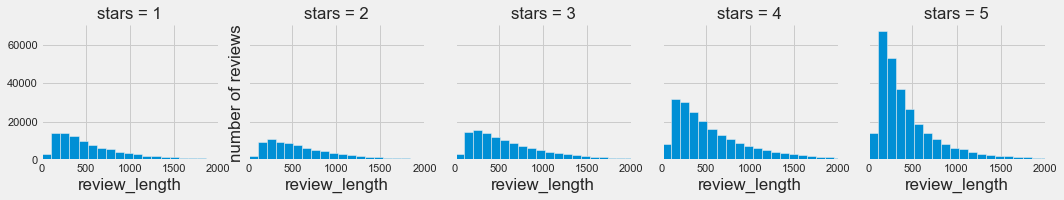

In [330]:
# check how the review lengths are distributed
reviews_df['review_length'] = reviews_df.text.map(len)

ax = sns.FacetGrid(data=reviews_df, col='stars', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)

ax.axes[0][1].set(ylabel='number of reviews');

## Run for specific City+Cuisine

In [580]:
pos_reviews = reviews_df.text[(reviews_df.city == 'Toronto') & (reviews_df.cuisine == 'american') &\
                              (reviews_df.label == 1)].values

neg_reviews = reviews_df.text[(reviews_df.city == 'Toronto') & (reviews_df.cuisine == 'american') &\
                              (reviews_df.label == -1)].values

print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  26,480
Negative Reviews:  5,134


In [551]:
reviews_df['city'].unique()

array(['Las Vegas', 'Toronto', 'Calgary'], dtype=object)

In [581]:
# additional stopwords
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'american','toronto','just', 
               'don', 'really', 'said', 'told', 'ok',
               'came', 'went', 'did', 'didn', 'good', 'kim', 'pho']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [582]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 20000
random_neg = np.random.choice(neg_reviews, size=num_reviews)
random_pos = np.random.choice(pos_reviews, size=num_reviews)

dicty = {'pizzas':'pizza', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings', 'noodle':'noodles', 'dumpling':'dumplings'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_neg = [replace_words(w, dicty) for w in random_neg]
random_pos = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(random_neg)
pos_vectors = tfidf_pos.fit_transform(random_pos)

Wall time: 3.29 s


In [583]:
# Store TFIDF vectors in a Pandas DataFrame to investigate further
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
pos_df = pd.DataFrame(pos_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each column (word): highest means are most important words
col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()

In [584]:
no_top_words = 10

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 10 words in POSITIVE reviews:[('great',), ('place',), ('service',), ('order',), ('chicken',), ('nice',), ('time',), ('menu',), ('burger',), ('restaurant',)]
Top 10 words in NEGATIVE reviews:[('service',), ('place',), ('order',), ('time',), ('chicken',), ('restaurant',), ('burger',), ('bad',), ('server',), ('table',)]


In [585]:
# delete dataframes to save memory
del neg_df
del pos_df

In [586]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)

In [587]:
# create LSA model
num_topics = 7
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

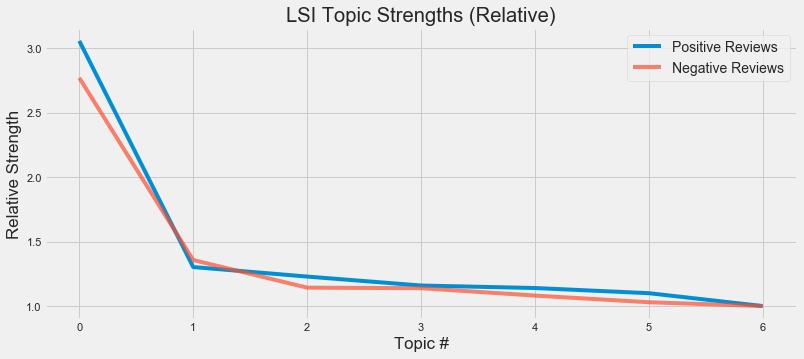

In [588]:
# elbow plot
singular_values_pos = lsi_pos.projection.s.tolist()
singular_values_pos_rel = [sv/singular_values_pos[-1] for sv in singular_values_pos]
singular_values_neg = lsi_neg.projection.s.tolist()
singular_values_neg_rel = [sv/singular_values_neg[-1] for sv in singular_values_neg]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_pos)), singular_values_pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(singular_values_neg)), singular_values_neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_pos)), range(len(singular_values_pos)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [589]:
topics_to_print = 5

In [590]:
# look at top positive topics
print('Top %d topics for POSITIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_pos.show_topics()[0:topics_to_print])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0,
  '0.210*"great" + 0.199*"place" + 0.161*"service" + 0.151*"order" + '
  '0.138*"chicken" + 0.128*"time" + 0.126*"nice" + 0.122*"burger" + '
  '0.121*"menu" + 0.114*"restaurant"'),
 (1,
  '-0.409*"great" + 0.369*"chicken" + 0.213*"burger" + -0.186*"place" + '
  '0.174*"fried" + 0.166*"fries" + -0.162*"service" + 0.143*"order" + '
  '-0.138*"drinks" + 0.138*"sauce"'),
 (2,
  '-0.615*"burger" + -0.219*"fries" + -0.193*"great" + -0.193*"wings" + '
  '-0.159*"beer" + -0.159*"place" + 0.135*"restaurant" + 0.132*"brunch" + '
  '0.117*"dessert" + -0.113*"chicken"'),
 (3,
  '0.370*"chicken" + -0.356*"burger" + 0.341*"brunch" + 0.239*"great" + '
  '0.167*"breakfast" + 0.162*"fried" + 0.158*"eggs" + 0.155*"pancakes" + '
  '0.152*"waffles" + -0.109*"restaurant"'),
 (4,
  '-0.439*"burger" + -0.375*"brunch" + 0.302*"wings" + 0.284*"chicken" + '
  '-0.216*"eggs" + -0.205*"breakfast" + -0.180*"pancakes" + 0.140*"bar" + '
  '0.13

In [591]:

# look at top negative topics
print('Top %d topics for NEGATIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_neg.show_topics()[0:topics_to_print])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0,
  '0.225*"service" + 0.205*"order" + 0.193*"place" + 0.163*"time" + '
  '0.131*"minutes" + 0.130*"restaurant" + 0.127*"server" + 0.126*"table" + '
  '0.123*"chicken" + 0.121*"bad"'),
 (1,
  '0.422*"burger" + 0.306*"chicken" + -0.229*"minutes" + 0.205*"fries" + '
  '-0.187*"table" + 0.135*"dry" + -0.125*"service" + -0.121*"wait" + '
  '-0.114*"server" + -0.114*"waited"'),
 (2,
  '0.382*"chicken" + -0.354*"place" + 0.271*"order" + -0.241*"bar" + '
  '0.190*"minutes" + -0.186*"service" + -0.155*"beer" + -0.124*"great" + '
  '0.122*"took" + 0.104*"server"'),
 (3,
  '0.732*"burger" + -0.353*"chicken" + -0.243*"wings" + 0.142*"minutes" + '
  '0.112*"fries" + -0.098*"place" + -0.093*"waffles" + 0.086*"took" + '
  '-0.078*"great" + 0.072*"patty"'),
 (4,
  '-0.627*"wings" + -0.272*"bar" + -0.219*"beer" + 0.147*"eggs" + '
  '0.132*"restaurant" + 0.130*"steak" + -0.121*"burger" + 0.114*"brunch" + '
  '-0.111*"sports" + 0.107

In [592]:

%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 3.92 s


In [593]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 10

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   0.952*restaurant, 0.861*order, 0.772*menu, 0.666*dessert, 0.654*experience, 0.634*meal, 0.575*dinner, 0.553*salad, 0.534*time, 0.514*table
Topic 1:   2.155*chicken, 0.928*fried, 0.582*ribs, 0.525*pork, 0.522*fries, 0.515*sauce, 0.511*waffles, 0.509*sandwich, 0.476*bbq, 0.393*brisket
Topic 2:   3.006*burger, 0.809*fries, 0.292*rings, 0.279*cheese, 0.278*onion, 0.275*bun, 0.248*patty, 0.215*order, 0.208*poutine, 0.194*beef
Topic 3:   1.472*place, 1.153*bar, 0.915*drinks, 0.879*beer, 0.696*wings, 0.593*nice, 0.590*night, 0.529*patio, 0.524*pretty, 0.518*drink
Topic 4:   1.873*brunch, 1.032*eggs, 0.938*breakfast, 0.867*pancakes, 0.652*wait, 0.579*toast, 0.479*bacon, 0.476*coffee, 0.411*french, 0.394*benedict
Topic 5:   2.455*great, 0.852*service, 0.627*atmosphere, 0.626*friendly, 0.614*staff, 0.576*amazing, 0.380*place, 0.354*excellent, 0.351*definitely, 0.308*recommend

Top topics + words for NEGATI

In [594]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])


17090
Had a business B'fast yesterday. It was great. The place was clean bright and the staff pleasant. The food was plain but well-prepared and tasty. The T-bone steak and eggar was prepared properly, medium rare. Overall was a good experience.


In [595]:
# look at a random negative review
review_num = np.random.randint(0, high=len(random_neg))
print(review_num)
print(random_neg[review_num])


10205






TERRIBLE first impression.  TERRIBLE service.  Never setting foot in there again!


In [596]:

# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [597]:

# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
So many choices... too many choices. I like places that kind of specialize in a few foods.. this place served everything! It wasn't bad. Whatever my girlfriend had had way too many onions and her breath smelled bad for the rest of the night. I had some pasta which was pretty good. It's about as expensive as you'd expect for Toronto, nothing outrageous.
--------------------------------------------------
>> Similarity 0.998
I came to Beer Bistro with some high hopes after reading their beer list online and seeing their menu. Tons of bottles and drafts to choose from. Hey, they even have Brooklyn! Can't find that at Esplanade Bier Markt. And I went during mussels month with all types of moules frites specials. Well, nothing wrong with the beer. In fact, they even offer samplers so you can try more and more types and varieties. But the food was the problem. The frites were decent but the moules were super-chewy with not

In [598]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(neg_reviews, size=num_reviews)
cv_random_pos = np.random.choice(pos_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [599]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [600]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=5, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=5, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

Wall time: 2min 26s


In [601]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
pprint(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
pprint(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0,
  '0.023*"place" + 0.014*"great" + 0.011*"bar" + 0.010*"service" + '
  '0.007*"drinks" + 0.007*"night" + 0.007*"time"'),
 (1,
  '0.014*"great" + 0.013*"brunch" + 0.009*"service" + 0.009*"place" + '
  '0.008*"menu" + 0.008*"eggs" + 0.007*"order"'),
 (2,
  '0.018*"chicken" + 0.015*"burger" + 0.015*"order" + 0.010*"fries" + '
  '0.008*"time" + 0.008*"place" + 0.008*"sauce"'),
 (3,
  '0.013*"service" + 0.012*"restaurant" + 0.010*"order" + 0.009*"great" + '
  '0.008*"menu" + 0.007*"time" + 0.006*"experience"'),
 (4,
  '0.008*"great" + 0.007*"delicious" + 0.007*"place" + 0.006*"service" + '
  '0.006*"order" + 0.006*"pork" + 0.006*"nice"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0,
  '0.023*"service" + 0.012*"time" + 0.012*"place" + 0.010*"order" + '
  '0.008*"bar" + 0.007*"table" + 0.007*"wait"'),
 (1,
  '0.014*"order" + 0.013*"service" + 0.013*"place" + 0.009*"ser

## Continuing with NMF

In [602]:
# let's remind ourselves of the POSITIVE topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   0.952*restaurant, 0.861*order, 0.772*menu, 0.666*dessert, 0.654*experience, 0.634*meal, 0.575*dinner, 0.553*salad, 0.534*time, 0.514*table
Topic 1:   2.155*chicken, 0.928*fried, 0.582*ribs, 0.525*pork, 0.522*fries, 0.515*sauce, 0.511*waffles, 0.509*sandwich, 0.476*bbq, 0.393*brisket
Topic 2:   3.006*burger, 0.809*fries, 0.292*rings, 0.279*cheese, 0.278*onion, 0.275*bun, 0.248*patty, 0.215*order, 0.208*poutine, 0.194*beef
Topic 3:   1.472*place, 1.153*bar, 0.915*drinks, 0.879*beer, 0.696*wings, 0.593*nice, 0.590*night, 0.529*patio, 0.524*pretty, 0.518*drink
Topic 4:   1.873*brunch, 1.032*eggs, 0.938*breakfast, 0.867*pancakes, 0.652*wait, 0.579*toast, 0.479*bacon, 0.476*coffee, 0.411*french, 0.394*benedict
Topic 5:   2.455*great, 0.852*service, 0.627*atmosphere, 0.626*friendly, 0.614*staff, 0.576*amazing, 0.380*place, 0.354*excellent, 0.351*definitely, 0.308*recommend


In [603]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #18127
-------------------------
I am in love with this place!! Started with a strawberry daiquiri and I must say it is the best one I have ever had. They have a huge patio that overlooks the beach which is perfect for a nice sunny day. The food was also delicious and the waitstaff was hilarious and efficient.  I would go everyday if I could.
-------------------------
Topic 3: 0.0224
Topic 4: 0.0114
Topic 5: 0.0104
Topic 1: 0.0047
Topic 0: 0.0027
Topic 2: 0.0013


In [604]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.349*minutes, 1.172*table, 1.110*order, 0.955*server, 0.903*time, 0.854*asked, 0.844*took, 0.843*wait, 0.664*waited, 0.644*waitress
Topic 1:   1.919*chicken, 0.683*order, 0.670*sandwich, 0.624*salad, 0.542*steak, 0.488*fries, 0.484*dry, 0.432*fried, 0.410*cheese, 0.407*tasted
Topic 2:   1.650*place, 0.997*bar, 0.600*beer, 0.387*drinks, 0.371*people, 0.353*sports, 0.314*night, 0.298*patio, 0.297*decent, 0.294*drink
Topic 3:   2.894*burger, 0.698*fries, 0.350*cheese, 0.294*patty, 0.266*bun, 0.256*rings, 0.255*dry, 0.254*onion, 0.220*order, 0.204*poutine
Topic 4:   2.634*wings, 0.294*sauce, 0.275*beer, 0.243*wing, 0.239*order, 0.199*fries, 0.195*lb, 0.190*pound, 0.189*louis, 0.171*night
Topic 5:   2.240*service, 0.927*slow, 0.723*terrible, 0.712*bad, 0.541*horrible, 0.514*great, 0.494*poor, 0.429*overpriced, 0.415*restaurant, 0.389*location


In [605]:
# now investigate a random negative review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #3695
-------------------------








taptaptaptaptap
-------------------------
Topic 5: 0.0346
Topic 0: 0.0228
Topic 1: 0.0043
Topic 2: 0.0016
Topic 3: 0.0000
Topic 4: 0.0000


## Topic Modeling All Reviews 
At this point, we can see that our topics are relatively interpretable and match along with the reviews they're trying to categorize. Let's proceed with topic modeling all reviews and businesses using NMF.

In [606]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  26,480
Negative Reviews:  5,134


In [607]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words with defined dictionary 'dicty'
pos_reviews = [replace_words(w, dicty) for w in pos_reviews]
neg_reviews = [replace_words(w, dicty) for w in neg_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

Wall time: 2.91 s


In [608]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 4.65 s


In [609]:
no_topics = num_topics
no_top_words = 10

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   1.732*place, 1.319*bar, 1.166*beer, 0.941*drinks, 0.895*wings, 0.652*night, 0.636*pretty, 0.619*nice, 0.610*patio, 0.579*drink
Topic 1:   2.511*great, 0.900*service, 0.654*atmosphere, 0.614*amazing, 0.610*staff, 0.572*friendly, 0.373*definitely, 0.368*place, 0.363*recommend, 0.350*excellent
Topic 2:   3.279*burger, 0.910*fries, 0.326*rings, 0.309*onion, 0.281*patty, 0.270*cheese, 0.262*bun, 0.220*order, 0.191*beef, 0.174*potato
Topic 3:   2.570*chicken, 1.077*fried, 0.729*ribs, 0.662*sandwich, 0.648*sauce, 0.621*fries, 0.612*pork, 0.602*waffles, 0.531*bbq, 0.463*brisket
Topic 4:   1.939*brunch, 1.065*eggs, 0.983*breakfast, 0.931*pancakes, 0.672*wait, 0.597*toast, 0.511*coffee, 0.461*bacon, 0.445*french, 0.373*benedict
Topic 5:   0.831*order, 0.824*restaurant, 0.670*menu, 0.568*meal, 0.565*dessert, 0.550*experience, 0.515*time, 0.503*salad, 0.498*table, 0.470*steak

Topics for NEGATIVE reviews
---------------

# ONLY RUN FOR THE CITY+CUISINE APPLICABLE TO YOURS

In [610]:
# TORONTO AMERICAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Bar/Beer', 1:'Customer Service/Atmosphere', 2:'Burger/Fries', 
              3:'Chicken/Ribs/Sandwich', 4:'Brunch/Eggs', 5:'Order/Waiting Time'}

neg_topics = {0:'Waiting Time', 1:'Chicken/Sandwich', 2:'Beer/Bar/Drinks', 
              3:'BUrger/Fries', 4:'Wings/Sauce', 5:'Customer Service'}

t_amer_pos_topics = pos_topics
t_amer_neg_topics = neg_topics

In [ ]:
# CALGARY ITALIAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'', 1:'', 2:'', 
              3:'', 4:'', 5:''}

neg_topics = {0:'', 1:'', 2:'', 
              3:'', 4:'', 5:''}

c_ita_pos_topics = pos_topics
c_ita_neg_topics = neg_topics

In [530]:
# CALGARY CHINESE TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Soup/Pork', 1:'Dim Sum', 2:'Customer Service', 
              3:'Ginger Beef/Chicken', 4:'Pad Thai/Curry', 5:'Bubble Tea'}

neg_topics = {0:'Buffet/Atmosphere', 1:'Chicken/Soup', 2:'Dim Sum', 
              3:'Order/Waiting Time', 4:'Ginger Beef/Pork', 5:'Customer Service'}

c_chi_pos_topics = pos_topics
c_chi_neg_topics = neg_topics

In [476]:
# TORONTO ITALIAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Order/Waiting Time', 1:'Pizza', 2:'Customer Service', 
              3:'Pasta', 4:'Atmosphere'}

neg_topics = {0:'Customer Service', 1:'Pizza', 2:'Pasta', 
              3:'Order/Waiting Time', 4:'Atmosphere'}

t_ita_pos_topics = pos_topics
t_ita_neg_topics = neg_topics

In [363]:
# TORONTO CHINESE TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Waiting Time', 1:'Dim Sum', 2:'Dumplings', 
              3:'Noodles/Soup', 4:'Chicken Rice', 5:'Customer Service'}

neg_topics = {0:'Waiting Time', 1:'Dim Sum', 2:'Customer Service', 
              3:'Dumplings', 4:'Chicken Rice', 5:'Noodles/Soup'}

t_chi_pos_topics = pos_topics
t_chi_neg_topics = neg_topics

In [295]:
# LAS VEGAS CHINESE TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Chicken Rice/Shrimp', 1:'Dim Sum', 2:'Customer Service', 
              3:'Noodles/Soup', 4:'Waiting Time', 5:'Pad Thai/Curry'}

neg_topics = {0:'Price', 1:'Chicken Rice', 2:'Dim Sum', 
              3:'Waiting Time', 4:'Soup/Noodle', 5:'Customer Service'}

v_chi_pos_topics = pos_topics
v_chi_neg_topics = neg_topics

In [129]:
# LAS VEGAS AMERICAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Waiting Time', 1:'Burger/Fries/Shake', 2:'Customer Service', 
              3:'Breakfast/Eggs/Pancakes', 4:'Chicken/Waffles', 5:'Atmosphere'}

neg_topics = {0:'Atmosphere', 1:'Burger/Fries', 2:'Waiting Time', 
              3:'Chicken/Steak', 4:'Customer Service', 5:'Buffet/Price'}

v_amer_pos_topics = pos_topics
v_amer_neg_topics = neg_topics

In [130]:
# LAS VEGAS ITALIAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Waiting Time', 1:'Pizza', 2:'Price', 
              3:'Pasta/Chicken', 4:'Customer Service', 5:'Atmosphere'}

neg_topics = {0:'Waiting Time', 1:'Pizza', 2:'Delivery/Reservation', 
              3:'Chicken/Pasta', 4:'Customer Service', 5:'Atmosphere'}

v_ita_pos_topics = pos_topics
v_ita_neg_topics = neg_topics

In [ ]:
# CALGARY AMERICAN TOPICS

# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'', 1:'', 2:'', 
              3:'', 4:'', 5:''}

neg_topics = {0:'', 1:'', 2:'', 
              3:'', 4:'', 5:''}

c_amer_pos_topics = pos_topics
c_amer_neg_topics = neg_topics

In [531]:
print('Topic Dictionaries for POSITIVE reviews')
print('-'*39)
pos_topics



Topic Dictionaries for POSITIVE reviews
---------------------------------------


{0: 'Soup/Pork',
 1: 'Dim Sum',
 2: 'Customer Service',
 3: 'Ginger Beef/Chicken',
 4: 'Pad Thai/Curry',
 5: 'Bubble Tea'}

In [532]:
print('Topic Dictionaries for NEGATIVE reviews')
print('-'*39)
neg_topics

Topic Dictionaries for NEGATIVE reviews
---------------------------------------


{0: 'Buffet/Atmosphere',
 1: 'Chicken/Soup',
 2: 'Dim Sum',
 3: 'Order/Waiting Time',
 4: 'Ginger Beef/Pork',
 5: 'Customer Service'}

## Adding Topic Weights to Pandas DataFrame

In [533]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = reviews_df[['business_id', 'stars', 'text', 'review_length']][(reviews_df.city == 'Calgary') & (reviews_df.cuisine == 'italian') &\
                              (reviews_df.label == 1)].reset_index()
df_neg = reviews_df[['business_id', 'stars', 'text', 'review_length']][(reviews_df.city == 'Calgary') & (reviews_df.cuisine == 'italian') &\
                              (reviews_df.label == -1)].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

In [534]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.02613094 0.000437   0.08457819 0.0947894  0.         0.        ]
Sum of weights:  0.205935531591685


In [535]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.12688895 0.00212201 0.41070225 0.46028679 0.         0.        ]]
Sum of normalized weights:  1.0


In [536]:
# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [537]:
# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,QiRWdm4GkmtEMO_npOyBjA,2,"We went on Boxing Day, they were busy and the ...",437,0.196476,0.046365,0.058278,0.088875,0.000000,0.610006
1,jg37O7ANF7hqggS6bxUpcQ,1,Bland soup and terrible service. I don't know ...,131,0.288655,0.219540,0.000000,0.000000,0.000000,0.491805
2,jg37O7ANF7hqggS6bxUpcQ,2,"Terrible service , the servers were not friend...",288,0.000000,0.167955,0.000000,0.266047,0.339004,0.226993
3,jg37O7ANF7hqggS6bxUpcQ,2,This place is not as good as other viet restau...,110,0.939952,0.000000,0.000000,0.000000,0.000000,0.060048
4,jg37O7ANF7hqggS6bxUpcQ,5,"Savory Pho with Chicken, so good!!!!",36,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [538]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean',5:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean',5:'mean'}).reset_index()

In [539]:
df_pos_bsns.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,-r8SvItXXG6_T3mP5GXRAw,4.625000,8,712.875000,0.191907,0.017617,0.478255,0.162229,0.069903,0.080089
1,0gVPTer9PnXRmSjuHt-XgQ,3.888889,9,944.222222,0.187242,0.007360,0.166207,0.594204,0.030508,0.014479
2,1jxxXQYOdP91LkF2Mz9Q9Q,4.000000,4,423.500000,0.265271,0.000000,0.052772,0.272512,0.079026,0.330420
3,1oJG7PcNNNfazaSLOxwmmQ,4.500000,2,404.500000,0.410481,0.000000,0.228052,0.253979,0.107488,0.000000
4,2-l_q7HBRak5i6X46l0OHw,3.388889,18,976.722222,0.137392,0.016383,0.195692,0.018200,0.038069,0.594265


In [540]:
df_neg_bsns.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,0gVPTer9PnXRmSjuHt-XgQ,2.000000,1,704.000000,0.384271,0.177961,0.021335,0.021309,0.395124,0.000000
1,1jxxXQYOdP91LkF2Mz9Q9Q,1.000000,3,248.000000,0.275628,0.040522,0.000771,0.507829,0.080587,0.094664
2,2-l_q7HBRak5i6X46l0OHw,2.000000,3,424.000000,0.189803,0.000000,0.002240,0.571950,0.005816,0.230191
3,21aDJ_xLGcEDkcyQRexlOQ,1.833333,6,491.166667,0.198490,0.076140,0.034792,0.313335,0.322016,0.055227
4,2M3tt_0FfsDiy-DDWIH4dg,1.000000,1,197.000000,0.061496,0.000000,0.124043,0.673644,0.037946,0.102871


## Adding in Business Information 

In [541]:
restaurants_df['neighborhood'].head()

0      Westside
1     Southeast
2       Sunrise
3      Westside
4    Centennial
Name: neighborhood, dtype: object

In [542]:
# merge business name/city with topic data
df_pos_tot = df_pos_bsns.merge(restaurants_df[['business_id', 'name', 'city','neighborhood','latitude','longitude','cuisine','RestaurantsPriceRange2']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city','neighborhood','latitude','longitude','cuisine','RestaurantsPriceRange2', 'stars', 0, 1, 2, 3, 4,5]]

df_neg_tot = df_neg_bsns.merge(restaurants_df[['business_id', 'name', 'city','neighborhood','latitude','longitude','cuisine','RestaurantsPriceRange2']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city','neighborhood','latitude','longitude','cuisine','RestaurantsPriceRange2', 'stars', 0, 1, 2, 3, 4,5]]

In [543]:
df_pos_bsns[df_pos_bsns.business_id == 'jg37O7ANF7hqggS6bxUpcQ']

,business_id,stars,text,review_length,0,1,2,3,4,5
156,jg37O7ANF7hqggS6bxUpcQ,3.861111,36,622.833333,0.197244,0.020252,0.490782,0.107854,0.098136,0.085733


In [544]:
df_neg_bsns[df_neg_bsns.business_id == 'jg37O7ANF7hqggS6bxUpcQ']

,business_id,stars,text,review_length,0,1,2,3,4,5
134,jg37O7ANF7hqggS6bxUpcQ,3.0,5,130.2,0.337006,0.304949,0.026292,0.055292,0.067801,0.20866


In [376]:
df_pos_tot = df_pos_tot.drop_duplicates()
df_neg_tot = df_neg_tot.drop_duplicates()

In [545]:
# peek into business/topic distributions
df_pos_tot[df_pos_tot.business_id == 'jg37O7ANF7hqggS6bxUpcQ']

,business_id,name,city,neighborhood,latitude,longitude,cuisine,RestaurantsPriceRange2,stars,0,1,2,3,4,5
157,jg37O7ANF7hqggS6bxUpcQ,Pho Thanh Vietnamese Noodle House & Restaurant,Calgary,NaN,51.11154,-114.055896,chinese,1.0,3.861111,0.197244,0.020252,0.490782,0.107854,0.098136,0.085733


In [546]:
# peek into business/topic distributions
df_neg_tot[df_neg_tot.name == 'Pho Thanh Vietnamese Noodle House & Restaurant']

,business_id,name,city,neighborhood,latitude,longitude,cuisine,RestaurantsPriceRange2,stars,0,1,2,3,4,5
135,jg37O7ANF7hqggS6bxUpcQ,Pho Thanh Vietnamese Noodle House & Restaurant,Calgary,NaN,51.11154,-114.055896,chinese,1.0,3.0,0.337006,0.304949,0.026292,0.055292,0.067801,0.20866


In [121]:
# scores = df_pos_bsns[df_pos_bsns.business_id == 'zU9w_xRlQSRIYXxGo-HSOA'].iloc[:,-6:].values
# print(restaurants_df[restaurants_df.business_id == 'zU9w_xRlQSRIYXxGo-HSOA']['name'].values[0] + ' - Positive Reviews')
# print('-'*36)
# for n in pos_topics:
#     print('Topic {}: {:18} > {:.4f}'.format(n, pos_topics[n], scores[0][n]))

# print('')
# print('')
# print('')
    
# scores = df_neg_bsns[df_neg_bsns.business_id == 'zU9w_xRlQSRIYXxGo-HSOA'].iloc[:,-6:].values
# print(restaurants_df[restaurants_df.business_id =='zU9w_xRlQSRIYXxGo-HSOA']['name'].values[0] + ' - Negative Reviews')
# print('-'*36)
# for n in neg_topics:
#     print('Topic {}: {:18} > {:.4f}'.format(n, neg_topics[n], scores[0][n]))

In [137]:
# v_amer_pos = df_pos_tot.rename(columns={'0': 'Waiting Time', '1': 'Burger/Fries/Shake', '2': 'Customer Service', '3': 'Breakfast/Eggs/Pancakes',\
#                                         '4': 'Chicken/Waffles', '5': 'Atmosphere'})

# v_amer_neg = df_neg_tot.rename(columns={'0': 'Atmosphere', '1': 'Burger/Fries', '2': 'Waiting Time', '3': 'Chicken/Steak',\
#                                        '4': 'Customer Service', '5': 'Buffet/Price'})

In [219]:
# v_ita_pos = df_pos_tot.rename(columns={0:'Waiting Time', 1:'Pizza', 2:'Price',\
#                                        3:'Pasta/Chicken', 4:'Customer Service', 5:'Atmosphere'})

# v_ita_neg = df_neg_tot.rename(columns={0:'Waiting Time', 1:'Pizza', 2:'Delivery/Reservation',\
#                                        3:'Chicken/Pasta', 4:'Customer Service', 5:'Atmosphere'})

In [327]:
v_chi_pos = df_pos_tot.rename(columns={0:'Chicken Rice/Shrimp', 1:'Dim Sum', 2:'Customer Service',\
                                       3:'Noodles/Soup', 4:'Waiting Time', 5:'Pad Thai/Curry'})

v_chi_neg = df_neg_tot.rename(columns={0:'Price', 1:'Chicken Rice', 2:'Dim Sum', \
                                       3:'Waiting Time', 4:'Soup/Noodle', 5:'Customer Service'})

In [379]:
t_chi_pos = df_pos_tot.rename(columns={0:'Waiting Time', 1:'Dim Sum', 2:'Dumplings',\
                                       3:'Noodles/Soup', 4:'Chicken Rice', 5:'Customer Service'})

t_chi_neg = df_neg_tot.rename(columns={0:'Waiting Time', 1:'Dim Sum', 2:'Customer Service',\
                                       3:'Dumplings', 4:'Chicken Rice', 5:'Noodles/Soup'})

In [431]:
t_amer_pos = df_pos_tot.rename(columns={0:'Bar/Beer', 1:'Customer Service/Atmosphere', 2:'Burger/Fries',\
                                        3:'Chicken/Ribs/Sandwich', 4:'', 5:'Order/Waiting Time'})

t_amer_neg = df_neg_tot.rename(columns={0:'Waiting Time', 1:'Chicken/Sandwich', 2:'Beer/Bar/Drinks',\
                                        3:'BUrger/Fries', 4:'Wings/Sauce', 5:'Customer Service'})

In [493]:
t_ita_pos = df_pos_tot.rename(columns={0:'Order/Waiting Time', 1:'Pizza', 2:'Customer Service',\
                                       3:'Pasta', 4:'Atmosphere'})

t_ita_neg = df_neg_tot.rename(columns={0:'Customer Service', 1:'Pizza', 2:'Pasta',\
                                       3:'Order/Waiting Time', 4:'Atmosphere'})

In [548]:
c_chi_pos = df_pos_tot.rename(columns={0:'Soup/Pork', 1:'Dim Sum', 2:'Customer Service',\
                                       3:'Ginger Beef/Chicken', 4:'Pad Thai/Curry', 5:'Bubble Tea'})

c_chi_neg = df_neg_tot.rename(columns={0:'Buffet/Atmosphere', 1:'Chicken/Soup', 2:'Dim Sum',\
                                       3:'Order/Waiting Time', 4:'Ginger Beef/Pork', 5:'Customer Service'})

In [432]:
t_ita_pos.head()

,business_id,name,city,neighborhood,latitude,longitude,cuisine,RestaurantsPriceRange2,stars,Bar/Beer,Customer Service/Atmosphere,Burger/Fries,Chicken/Ribs/Sandwich,,Order/Waiting Time
0,-Fq75GKdSKwhTVISzyc6rw,Three's Company Catering,Toronto,Greektown,43.678997,-79.344287,american,2.0,3.750000,0.087416,0.114967,0.015788,0.024573,0.574306,0.182950
1,-TjzQsimpriXVYaH3HdtQA,Fanzone Wings & Ribs,Toronto,Scarborough,43.753057,-79.276234,american,2.0,4.395161,0.448432,0.160788,0.067190,0.253195,0.010440,0.059955
2,-W1bYeAk18xShlb6_Yb2Ig,Ciro's,Toronto,Bloordale Village,43.658482,-79.443120,american,2.0,3.083333,0.505054,0.145346,0.121909,0.023635,0.059268,0.144788
3,-Z7Oxv9nuPJI4ov4ufvvdA,Bon Appetit Cafe,Toronto,Downtown Core,43.652321,-79.379380,american,1.0,3.333333,0.391360,0.079380,0.042159,0.049913,0.107265,0.329922
4,-dOjdFq-kFhQTrG-yLYc_w,Maple Leaf Tavern,Toronto,Leslieville,43.668111,-79.339801,american,3.0,3.923077,0.169347,0.245691,0.069448,0.033048,0.091515,0.390950


In [549]:
%%time
# write to CSV
c_chi_pos.to_csv('datasets/pos_bsns_c_chi.csv', index=False)
c_chi_neg.to_csv('datasets/neg_bsns_c_chi.csv', index=False)
# df_pos.to_csv('datasets/pos_reviews_v_amer.csv', index=False)
# df_neg.to_csv('datasets/neg_reviews_v_amer.csv', index=False)

Wall time: 31.6 ms
